In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from math import sqrt
# to turn off pink warning boxes basically for display purposes in class
# import warnings
# warnings.filterwarnings('ignore')

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# classification algorithms
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# classification analysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# to see local file system
import os

# import our own modules
import env
import acquire as a
import prepare as p

# jupyter settings
%matplotlib inline

In [6]:
train, val, test = p.wrangle_telco()

In [7]:
train.head().T

,4841,852,2923,4162,4261
gender,Female,Male,Male,Male,Female
senior_citizen,0,1,1,0,0
partner,No,No,Yes,No,Yes
dependents,No,No,Yes,Yes,Yes
tenure,37,14,43,1,27
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,Yes,No,Yes,Yes,No
online_security,Yes,No,No,No,No internet service
online_backup,Yes,No,Yes,No,No internet service
device_protection,Yes,No,Yes,No,No internet service


In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 4841 to 2574
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 3943 non-null   object 
 1   senior_citizen                         3943 non-null   int64  
 2   partner                                3943 non-null   object 
 3   dependents                             3943 non-null   object 
 4   tenure                                 3943 non-null   int64  
 5   phone_service                          3943 non-null   object 
 6   multiple_lines                         3943 non-null   object 
 7   online_security                        3943 non-null   object 
 8   online_backup                          3943 non-null   object 
 9   device_protection                      3943 non-null   object 
 10  tech_support                           3943 non-null   object 
 11  s

In [8]:
# finally on to some bivariate exploration

train.monthly_charges.mode()


0    20.05
1    20.15
Name: monthly_charges, dtype: float64

In [31]:
train.monthly_charges.median()

70.3

In [32]:
train.monthly_charges.mean()

64.38212021303565

In [22]:
train[train.monthly_charges < 30]['monthly_charges'].value_counts()

20.15    30
20.05    30
19.90    27
19.85    27
20.00    25
         ..
21.15     1
29.70     1
18.75     1
22.95     1
29.45     1
Name: monthly_charges, Length: 132, dtype: int64

In [23]:
train[train.monthly_charges < 30]['monthly_charges'].value_counts().sum()

938

In [24]:
train.shape

(3943, 47)

In [25]:
train.monthly_charges.describe()

count    3943.000000
mean       64.382120
std        30.032871
min        18.250000
25%        35.300000
50%        70.300000
75%        89.650000
max       118.200000
Name: monthly_charges, dtype: float64

In [26]:
# the bottom 25% pays $35.30 or less per month. What plan are they on?
train[train.monthly_charges < 30]['contract_type'].value_counts()

Two year          379
Month-to-month    343
One year          216
Name: contract_type, dtype: int64

In [27]:
# interestingly, customers in the bottom quartile of monthly
# charges are pretty evenly distributed across contract types.
# what if we lower to less than $22/mo?
train[train.monthly_charges < 22]['contract_type'].value_counts()

Month-to-month    261
Two year          238
One year          169
Name: contract_type, dtype: int64

In [28]:
# month-to-month gains share, but still somewhat evenly distributed.
# lets look at the bottom 25% of tenure v. plan-type.
train.tenure.describe()

count    3943.000000
mean       32.248542
std        24.427210
min         0.000000
25%         9.000000
50%        28.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [30]:
# 9 months or less for bottom quartile
train[(train['tenure'] <= 9)]['contract_type'].value_counts()

Month-to-month    949
One year           40
Two year           29
Name: contract_type, dtype: int64

In [34]:
# this makes sense as long-term contracts would have to be broken.
# what about at long end of the tenure spectrum?
train[(train['tenure'] >= 55)]['contract_type'].value_counts()

Two year          643
One year          244
Month-to-month    114
Name: contract_type, dtype: int64

In [36]:
train[(train['tenure'] >= 55)]['contract_type'].value_counts(normalize=True)

Two year          0.642358
One year          0.243756
Month-to-month    0.113886
Name: contract_type, dtype: float64

In [38]:
# here two-year contracts are by far the majority

In [39]:
# what about in the upper 25% of monthly cost?
train[train.monthly_charges >= 89.65]['contract_type'].value_counts()

Month-to-month    508
Two year          256
One year          226
Name: contract_type, dtype: int64

In [42]:
train[train.monthly_charges >= 89.65]['contract_type'].value_counts(normalize=True)

Month-to-month    0.513131
Two year          0.258586
One year          0.228283
Name: contract_type, dtype: float64

In [48]:
# refresh memory on distribution of contract type:
train.contract_type.value_counts(normalize=True)

Month-to-month    0.549328
Two year          0.247781
One year          0.202891
Name: contract_type, dtype: float64

In [49]:
# In the upper quartile of monthly charges the distribution of
# contract types is very close to the distribution in the quartile.

In [58]:
# now lets check do bivariates of all categorical features v churn

cat_cols, num_cols = [], []
for col in train.columns:
    if train[col].dtype == 'O':
        cat_cols.append(col)
    else:
        if train[col].nunique() < 10:
            cat_cols.append(col)
        else:
            num_cols.append(col)

In [59]:
cat_cols

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'internet_service_type',
 'contract_type',
 'payment_type',
 'gender_encoded',
 'partner_encoded',
 'dependents_encoded',
 'phone_service_encoded',
 'paperless_billing_encoded',
 'churn_encoded',
 'multiple_lines_No phone service',
 'multiple_lines_Yes',
 'online_security_No internet service',
 'online_security_Yes',
 'online_backup_No internet service',
 'online_backup_Yes',
 'device_protection_No internet service',
 'device_protection_Yes',
 'tech_support_No internet service',
 'tech_support_Yes',
 'streaming_tv_No internet service',
 'streaming_tv_Yes',
 'streaming_movies_No internet service',
 'streaming_movies_Yes',
 'contract_type_One year',
 'contract_type_Two year',
 'internet_service_type_Fiber optic',
 'internet_service_type_None',
 'paym

In [61]:
# this now captures all of the encoded columns so removing them here

In [65]:
cat_cols = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'internet_service_type',
 'contract_type',
 'payment_type']

In [63]:
num_cols

['tenure', 'monthly_charges', 'total_charges']

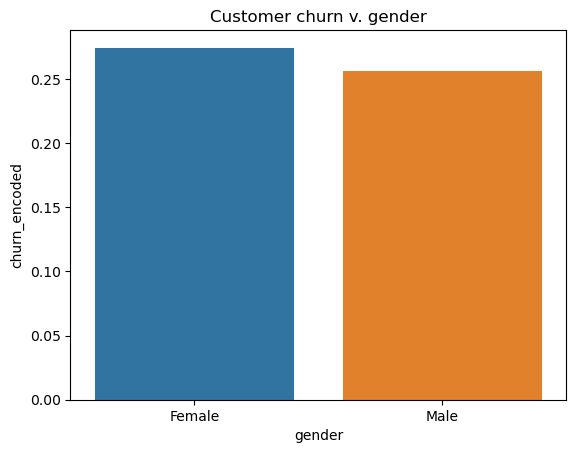

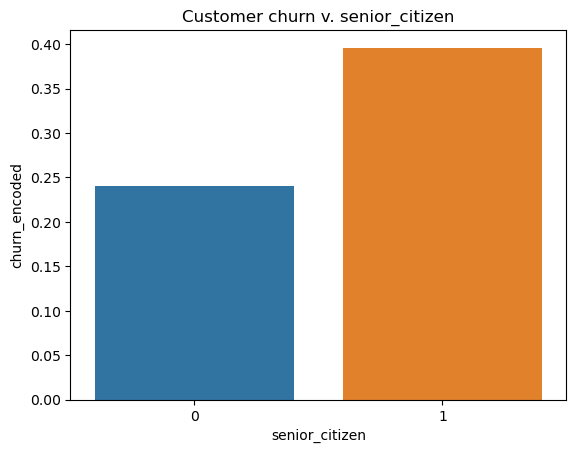

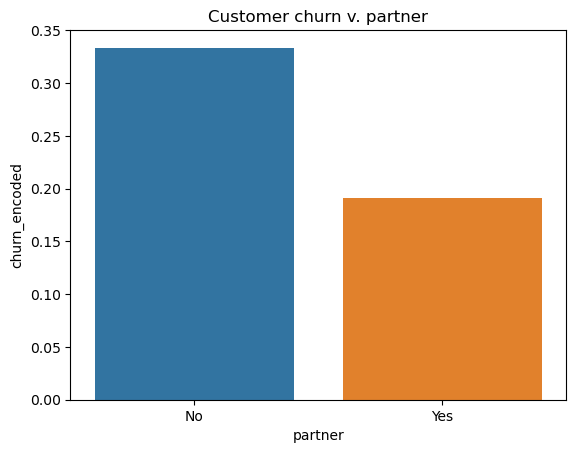

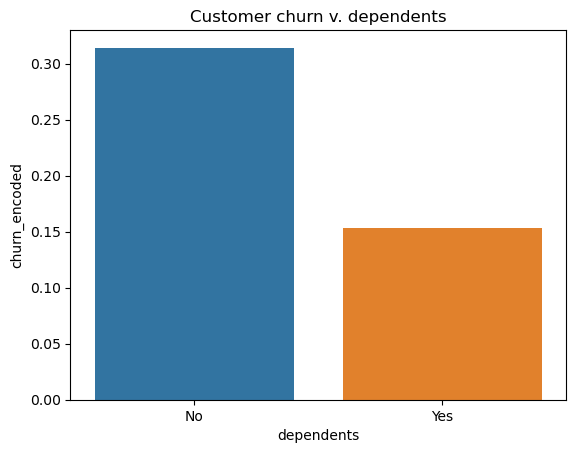

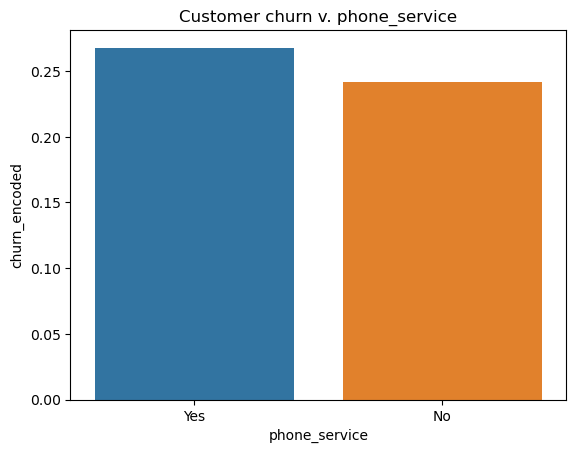

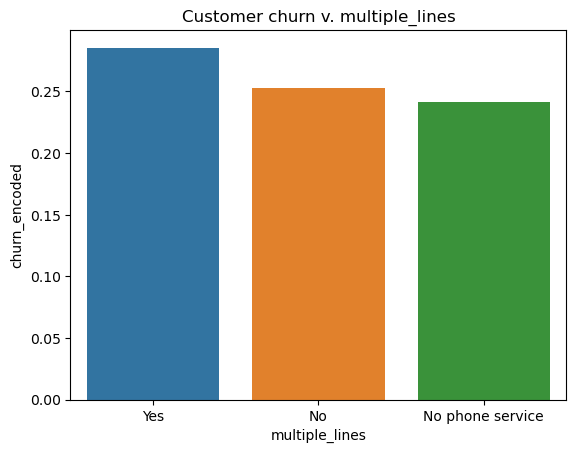

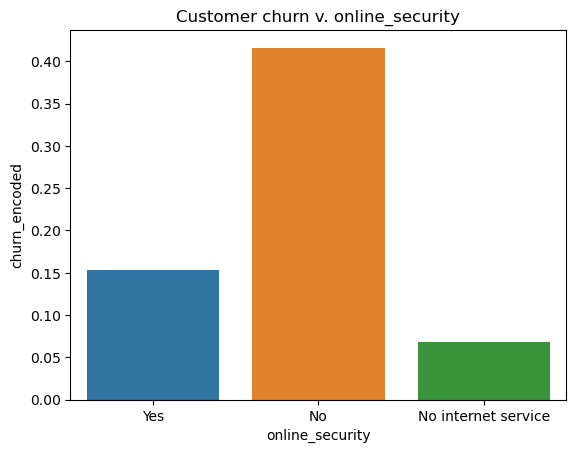

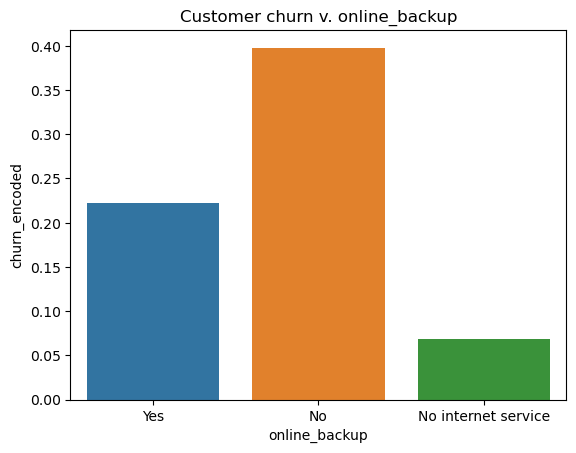

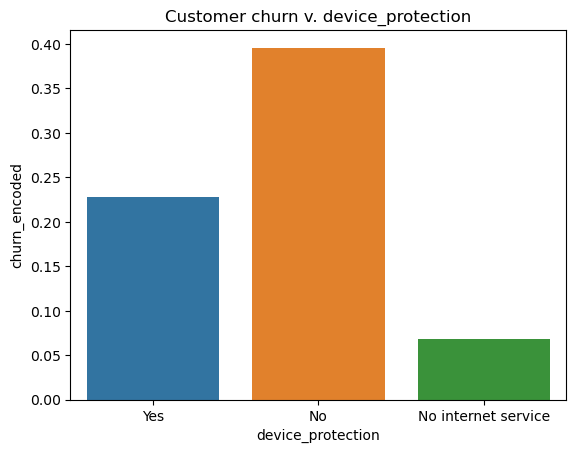

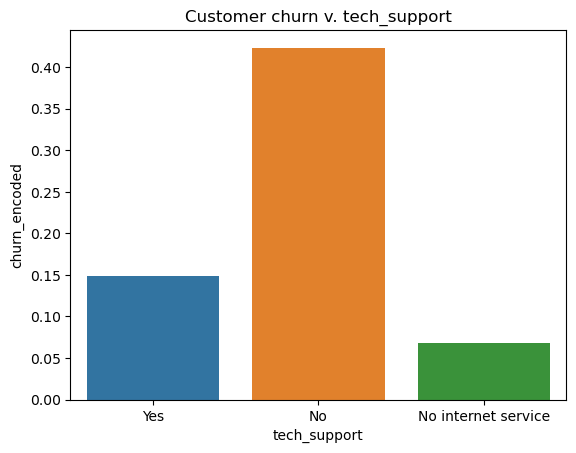

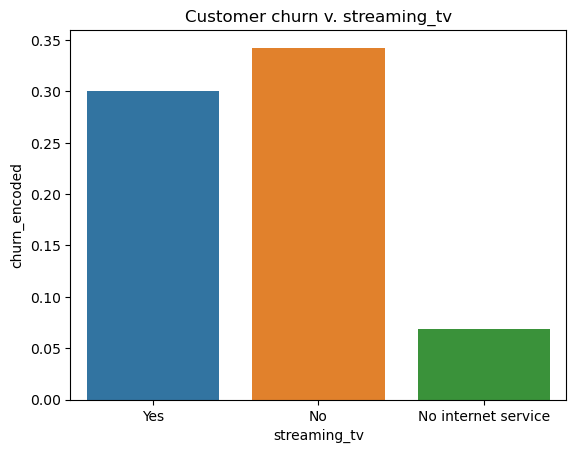

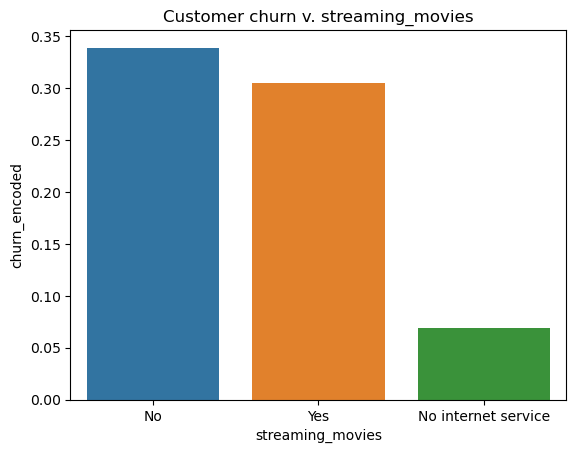

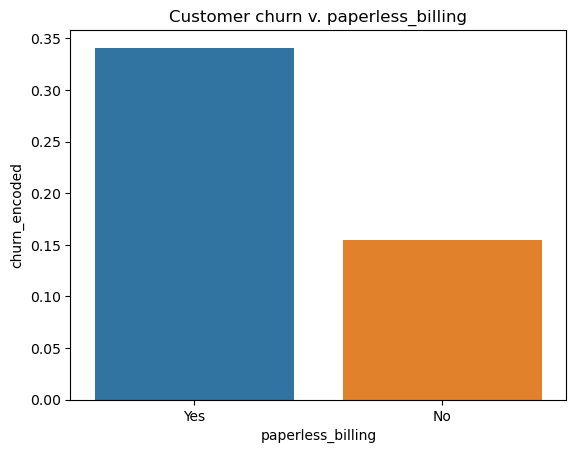

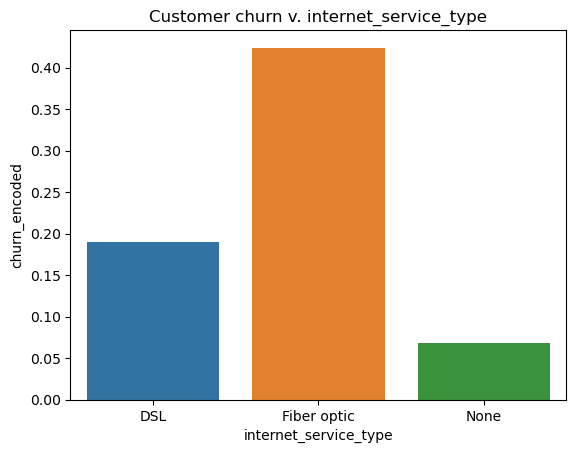

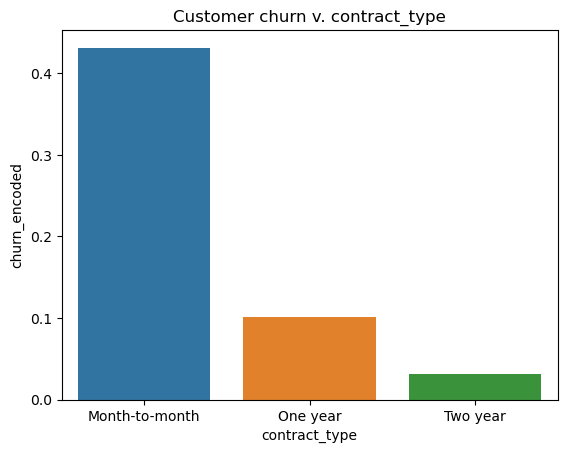

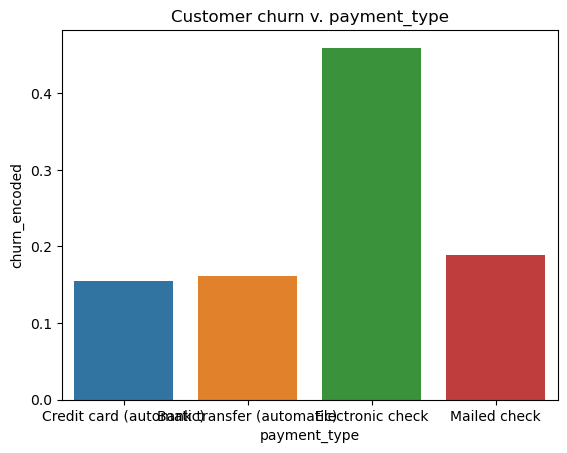

In [67]:
for col in cat_cols:
    if col != 'churn_encoded':
        sns.barplot(data=train,
                    x=col,
                    y = 'churn_encoded',
                   ci=False)
        plt.title(f'Customer churn v. {col}')
        plt.show()